## Bird Species Prediction

I will create a Convolutional Neural Network which will be able to predict the species of a bird.   The CUB-200–2011 dataset contains images of North American birds from a range of 200 different species. It is a challenging problem as many of the species of birds have degree of visual similarity. Bird species identification can be challenging for humans, let alone computer vision algorithms, hence this type of problem is often referred to as Large Scale Fine-Grained.

The dataset was originally produced in 2010 (CUB-200), and contained ~6000 images of the 200 classes of birds. Accompanying this was additional label data including bounding boxes, rough segmentations and additional attributes. This was updated in 2011 (CUB-200–2011), to add additional images, bringing the total number of images in the dataset to almost 12,000. The available attributes were also updated to include 15 part locations, 312 binary attributes and a bounding box per image. 

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2
import random
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from sklearn.model_selection import train_test_split

I will visualise some of the bird images that I will be working with,  I will also observe the x and y dimensions of the images. 

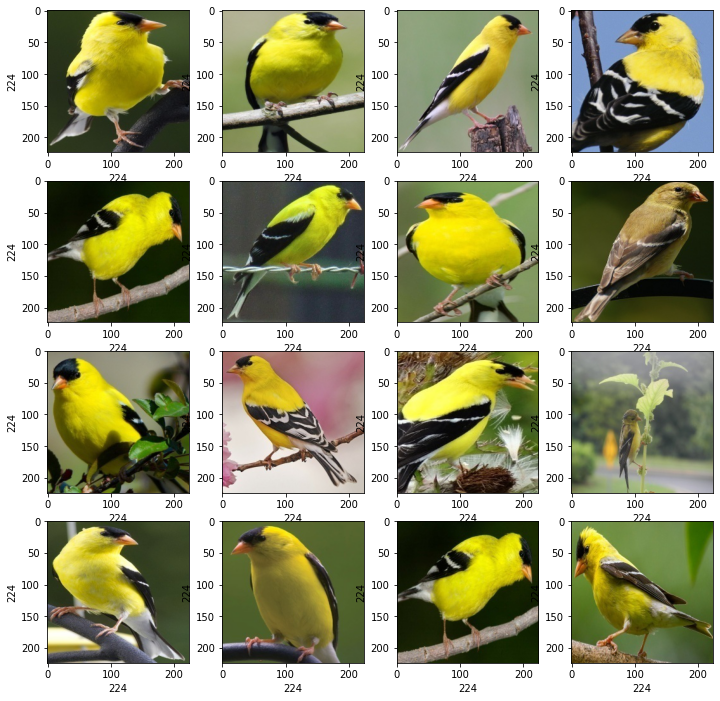

In [2]:
plt.figure(figsize=(12,12))
path = "/content/drive/MyDrive/ML Projects/BirdSpeciesData/AMERICAN GOLDFINCH"
for i in range(1,17):
  plt.subplot(4,4,i)
  rand_img = imread(path + "/" + random.choice(sorted(listdir(path))))
  plt.imshow(rand_img)
  plt.xlabel(rand_img.shape[1], fontsize = 10)
  plt.ylabel(rand_img.shape[0], fontsize = 10)


Setting the root directory for the dataset and storing all the folder names.  I will also create 2 empty lists for images and labels. 

In [3]:
dir = "/content/drive/MyDrive/ML Projects/BirdSpeciesData"
root_dir = listdir(dir)
image_list, label_list = [], []

I will now read all the timages and convert them into an array and append the empty lists with the images and their labels. 

In [4]:
for directory in root_dir:
  for files in listdir(f"{dir}/{directory}"):
    image_path = f"{dir}/{directory}/{files}"
    image = cv2.imread(image_path)
    image = img_to_array(image)
    image_list.append(image)
    label_list.append(directory)

Check for any class imbalances

In [5]:
label_counts = pd.DataFrame(label_list).value_counts()
label_counts

AMERICAN GOLDFINCH    143
EMPEROR PENGUIN       139
DOWNY WOODPECKER      137
FLAMINGO              132
CARMINE BEE-EATER     131
BARN OWL              129
dtype: int64

I can see there are a different amounts of images within each class,  but they are between 130-40 so no real imbalance.  

Next, I will store the number of classes as I will be using it later in the model architecture.

In [6]:
num_classes = len(label_counts)
num_classes

6

Checking the size of the images: 

In [7]:
image_list[0].shape

(224, 224, 3)

Check total image count: 

In [8]:
label_list = np.array(label_list)
label_list.shape

(811,)

Split the data into test and train: 

In [9]:
x_train, x_test, y_train, y_test = train_test_split(image_list, label_list, test_size=0.2, random_state=42)

Now, to normalise the images in our testing and training data

In [10]:
x_train = np.array(x_train, dtype=np.float16) / 255.0
x_test = np.array(x_test, dtype=np.float16) / 255.0
x_train = x_train.reshape(-1, 224,224,3)
x_test = x_test.reshape(-1, 224,224,3)

Next, I will use a label binarizer; one hot encode to the y data.  

In [11]:
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)
print(lb.classes_)

['AMERICAN GOLDFINCH' 'BARN OWL' 'CARMINE BEE-EATER' 'DOWNY WOODPECKER'
 'EMPEROR PENGUIN' 'FLAMINGO']


Split the traning data into train and validation

In [12]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2)

It's time to build the CNN architecture for the model.  I will use different types of layers according to their features:  

**Conv_2d:**  is used to create a Convolutional Kernel that is colnvolved with the input layer to produce the output tensor. 
 
**Max_pooling2d:**  is a downsampling technique which takes out the maximum value over the window defined by the poolsize. 

**Flatten:** flattens the input and creates a 1D output. 

**Dense:** the dense layer produce the output as the dot product of input and kernel. 

In [13]:
model = Sequential()
model.add(Conv2D(8, (3,3), padding = "same", input_shape = (224,224,3), activation = "relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(16, (3,3), padding = "same", activation = "relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (3,3), padding = "same", activation = "relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(32, activation = "relu"))
model.add(Dense(num_classes, activation = "softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 74, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 32)       0

338k params are trainable, with 0 non-trainable params. 

Trainable parameters are those which value is adjusted/modified during training as per their gradient. 

Non trainable parameters are those which value is not optimized during the training as per their gradient.

I can now compile the model. I have set the type of loss as a binary crossentropy as well as set the optimiser and metric.

In [14]:
model.compile(loss = "categorical_crossentropy", optimizer = Adam(0.0005), metrics = ["accuracy"])

I will now train the model.  

In [15]:
epochs = 100
batch_size = 128
history = model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (x_val, y_val))

Epoch 1/100
5/5 [==============================] - 7s 277ms/step - loss: 1.8122 - accuracy: 0.1718 - val_loss: 1.7893 - val_accuracy: 0.1231
Epoch 2/100
5/5 [==============================] - 1s 119ms/step - loss: 1.7406 - accuracy: 0.2181 - val_loss: 1.7281 - val_accuracy: 0.3077
Epoch 3/100
5/5 [==============================] - 0s 96ms/step - loss: 1.6983 - accuracy: 0.3436 - val_loss: 1.6814 - val_accuracy: 0.3231
Epoch 4/100
5/5 [==============================] - 0s 91ms/step - loss: 1.6426 - accuracy: 0.3822 - val_loss: 1.6740 - val_accuracy: 0.3231
Epoch 5/100
5/5 [==============================] - 1s 116ms/step - loss: 1.5931 - accuracy: 0.3533 - val_loss: 1.6294 - val_accuracy: 0.2615
Epoch 6/100
5/5 [==============================] - 1s 96ms/step - loss: 1.5117 - accuracy: 0.4344 - val_loss: 1.5270 - val_accuracy: 0.4692
Epoch 7/100
5/5 [==============================] - 0s 99ms/step - loss: 1.4583 - accuracy: 0.5135 - val_loss: 1.5800 - val_accuracy: 0.3846
Epoch 8/100
5/5 [

It looks like the model has been overfitted - the difference between the accuracy and the val accuracy seems to be quite significant. 

I can combat this in two ways - reducing the number of Epochs or using dropout regularisation. 

```
model.add(Conv2D(8, (3,3), padding = "same", input_shape = (224,224,3), activation = "relu"))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Conv2D(16, (3,3), padding = "same", activation = "relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (3,3), padding = "same", activation = "relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))
```

Dropout can be used after convolutional layers (e.g. Conv2D) and after pooling layers (e.g. MaxPooling2D). In this case, dropout is applied to each element or cell within the feature maps.

In [16]:
model.save("/content/drive/MyDrive/ML Projects/BirdSpeciesData/bird+species.h5")

I will plot the training history.

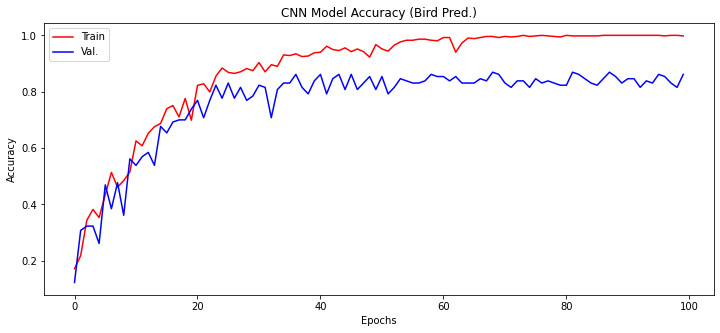

In [17]:
plt.figure(figsize=(12,5))
plt.plot(history.history["accuracy"], color="r")
plt.plot(history.history["val_accuracy"], color="b")
plt.title("CNN Model Accuracy (Bird Pred.)")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Val."])
plt.show()

I will also plot the loss history.

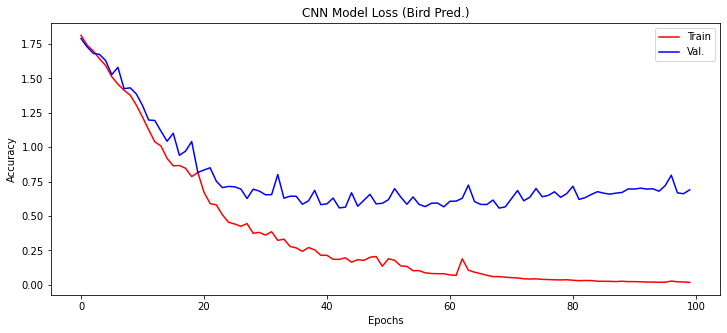

In [18]:
plt.figure(figsize=(12,5))
plt.plot(history.history["loss"], color="r")
plt.plot(history.history["val_loss"], color="b")
plt.title("CNN Model Loss (Bird Pred.)")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["Train", "Val."])
plt.show()

Evalulating the model to know the accuracy of the model on the test data. 

In [19]:
scores = model.evaluate(x_test, y_test)
print(f"Test accuracy: {scores[1]*100}")

6/6 [==============================] - 0s 28ms/step - loss: 0.7291 - accuracy: 0.7914
Test accuracy: 79.141104221344


I will store the predictions on the test data. 

In [20]:
y_pred = model.predict(x_test)

Now to randomly choose an image to predict. 

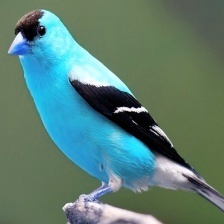

In [21]:
img = array_to_img(x_test[5])
img

Now to predict on a randomly selected image. 

In [23]:
labels = lb.classes_
print(labels)

print("Original Image: ", labels[np.argmax(y_test[5])])
print("Predicted: ", labels[np.argmax(y_pred[5])])

['AMERICAN GOLDFINCH' 'BARN OWL' 'CARMINE BEE-EATER' 'DOWNY WOODPECKER'
 'EMPEROR PENGUIN' 'FLAMINGO']
Original Image:  AMERICAN GOLDFINCH
Predicted:  AMERICAN GOLDFINCH
